In [ ]:
!kaggle datasets download ahmedmohameddawoud/ecommerce-ab-testing

Dataset URL: https://www.kaggle.com/datasets/ahmedmohameddawoud/ecommerce-ab-testing
License(s): unknown


In [ ]:
!unzip /content/ecommerce-ab-testing.zip

Archive:  /content/ecommerce-ab-testing.zip
  inflating: ab_test.csv             
  inflating: countries_ab.csv        


# 1. Hypothesis of the Test
---
**H0: Conversion rate of the treatment group is equal to the control group.**

**H1: Conversion rate of the treatment group is different from the control group.**

# 2. Test Design

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load dataset
df = pd.read_csv("/content/ab_test.csv")

In [ ]:
print(df.columns)

Index(['id', 'time', 'con_treat', 'page', 'converted'], dtype='object')


In [ ]:
# Remove users that appear in both groups
df = df.drop_duplicates(subset='id')

In [ ]:
# Filter only valid group-landing_page pairs
df = df[((df['con_treat'] == 'control') & (df['page'] == 'old_page')) |
        ((df['con_treat'] == 'treatment') & (df['page'] == 'new_page'))]

# 3. Run the Test

In [ ]:
# Group stats
conversion = df.groupby('con_treat')['converted'].agg(['mean', 'sum', 'count'])
print("\nConversion Summary:\n", conversion)


Conversion Summary:
                mean    sum   count
con_treat                         
control    0.120290  17349  144226
treatment  0.118727  17134  144314


In [ ]:
# Z-test values
control_success = conversion.loc['control', 'sum']
treatment_success = conversion.loc['treatment', 'sum']
control_n = conversion.loc['control', 'count']
treatment_n = conversion.loc['treatment', 'count']

# 4. Statistical Significance Test

In [ ]:
z_stat, p_val = proportions_ztest(
    count=[treatment_success, control_success],
    nobs=[treatment_n, control_n],
    alternative='two-sided'
)

print(f"\nZ-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_val:.4f}")


Z-Statistic: -1.2942
P-Value: 0.1956


# 5. Practical Significance

In [ ]:
abs_diff = abs(conversion.loc['treatment', 'mean'] - conversion.loc['control', 'mean'])
print(f"Absolute Difference in Conversion Rates: {abs_diff:.4%}")

# MDE and power analysis
baseline = conversion.loc['control', 'mean']
mde = 0.01
effect_size = mde / np.sqrt(baseline * (1 - baseline))

analysis = NormalIndPower()
required_n = analysis.solve_power(effect_size=effect_size, power=0.8, alpha=0.05, ratio=1)

print(f"Required Sample Size per Group for 1% MDE: {int(required_n)}")
print(f"Actual Sample Sizes - Control: {control_n}, Treatment: {treatment_n}")

Absolute Difference in Conversion Rates: 0.1563%
Required Sample Size per Group for 1% MDE: 16611
Actual Sample Sizes - Control: 144226, Treatment: 144314


## Visualization

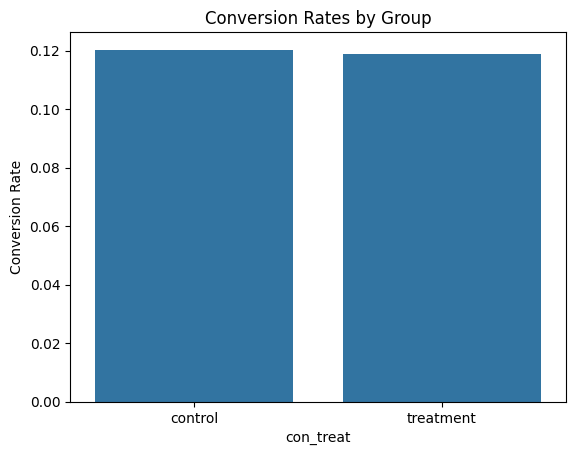

In [ ]:
sns.barplot(x=conversion.index, y=conversion['mean'])
plt.title("Conversion Rates by Group")
plt.ylabel("Conversion Rate")
plt.show()

# 6. Conclusion

In [ ]:
def make_ab_test_conclusion(p_value, abs_diff, threshold=0.01, alpha=0.05):
    print("\n--- Conclusion ---")
    if p_value < alpha:
        print("✅ Statistically significant result (reject H0)")
        if abs_diff >= threshold:
            print("📈 Practically significant. Recommend launching the new page.")
        else:
            print("⚠️ Statistically significant, but not practically. Do not launch.")
    else:
        print("❌ No statistically significant difference. Fail to reject H0.")
        if abs_diff >= threshold:
            print("⚠️ Practical difference exists. Consider retesting or increasing sample size.")
    print("------------------")

# Call the function
make_ab_test_conclusion(p_val, abs_diff, threshold=mde)


--- Conclusion ---
❌ No statistically significant difference. Fail to reject H0.
------------------
